# Extracting the data 

Data is being extracted from a json file and put into the respective dataframes.

In [1]:
import json
import pandas as pd
import csv
from pandas.io.json import json_normalize
import os
import numpy as np
from keras.layers import Activation, Conv1D, Dense, Embedding, Flatten, Input, MaxPooling1D
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences



with open('C:/Users/admin/Desktop/New_News_Data.json', 'r') as f:
    data = json.load(f)
    
df= pd.DataFrame(data)
print(df.shape)

headline=df['headline'] #extract text
category=df['category'] #extract target

print(headline[1],category[1])

unique_categories=df.category.unique()
unique_categories_dictionary=dict(zip(unique_categories,range(0,len(unique_categories))))
labels=df['category'].map(unique_categories_dictionary, na_action='ignore')
print(len(labels))


### The below code snippet was used to extract data from a json file and put into a dataframe.


#To convert bad json to good json
# count=0
# with open("C:/Users/admin/Desktop/News_Category_Dataset.json", "rt") as fin:
#     with open("C:/Users/admin/Desktop/New_News_Data.json", "wt") as fout:
#         for line in fin:
#             count=count+1
#             print(count,line)
#             fout.write(line.replace('}', '},'))
    #df = pd.DataFrame(data)
#     flatten_json=json_normalize(data)
#     headline=flatten_json['headline']
#     category=flatten_json['category']
    #print(df['headline'][:5],df['category'][:5])
#     print(headline.head())
#     print(category.head())
    
   

F:\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


(124989, 6)
Will Smith Joins Diplo And Nicky Jam For The 2018 World Cup's Official Song ENTERTAINMENT
124989


## Preprocessing the data

We tokenize the text before we can feed it into a neural network. This tokenization process will also remove some of the features of the original text, such as all punctuation or words that are less common.

We have to specify the size of our vocabulary. Words that are less frequent will get removed. In this case we want to retain the 20,000 most common words.

In [2]:
vocab_size = 20000
tokenizer = Tokenizer(num_words=vocab_size) # Setup tokenizer
tokenizer.fit_on_texts(headline)
sequences = tokenizer.texts_to_sequences(headline) # Generate sequences


In [3]:
print (len(sequences))  ## Testing the output of the tokenizer functions.
print (len(sequences[0]))
print (sequences[0])

124989
14
[372, 316, 147, 755, 1777, 4, 282, 243, 153, 79, 255, 185, 9, 266]


##### Word_index
Our text is now converted to sequences of numbers. It makes sense to convert some of those sequences back into text to check what the tokenization did to our text. To this end we create an inverse index that maps numbers to words while the tokenizer maps words to numbers.

In [4]:
word_index = tokenizer.word_index
print('Found {:,} unique words.'.format(len(word_index)))

Found 58,184 unique words.


In [5]:
#Create inverse index mapping numbers to words
inv_index = {v: k for k, v in tokenizer.word_index.items()}

# Print out text again
for w in sequences[0]:
    x = inv_index.get(w)
    print(x,end = ' ')

there were 2 mass shootings in texas last week but only 1 on tv 

#### Measuring the text length

Let's ensure all sequences have the same length.

In [6]:
# Get the average length of a text
avg = sum(map(len, sequences)) / len(sequences)

# Get the standard deviation of the sequence length
std = np.sqrt(sum(map(lambda x: (len(x) - avg)**2, sequences)) / len(sequences))

avg,std

(9.58399539159446, 2.945229148984206)

#### Using Average Length and SD of the text
You can see, the average text is about 9 words long.Standard deviation is around 3.So,we will make the maximum length of a text to be 12.( i.e 9+3 )

In [7]:
pad_sequences([[1,2,3]], maxlen=5) # testing the pad_sequences function

array([[0, 0, 1, 2, 3]])

In [8]:
max_length = 12
data = pad_sequences(sequences, maxlen=max_length)

### Turning labels into one-hot encodings

Labels can quickly be encoded into one-hot vectors with Keras:

In [9]:
from keras.utils import to_categorical
labels = to_categorical(np.asarray(labels))
print('Shape of data:', data.shape)
print('Shape of labels:', labels.shape)

Shape of data: (124989, 12)
Shape of labels: (124989, 31)


### Loading GloVe embeddings

A word embedding is a form of representing words and documents using a dense vector representation. The position of a word within the vector space is learned from text and is based on the words that surround the word when it is used. Word embeddings can be trained using the input corpus itself or can be generated using pre-trained word embeddings such as Glove, FastText, and Word2Vec.

In [10]:
glove_dir = 'C:/Users/admin/Desktop' # This is the folder with the dataset/glove embeddings

embeddings_index = {} # We create a dictionary of word -> embedding

with open(os.path.join(glove_dir, 'glove.6B.100d.txt'),encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0] # The first value is the word, the rest are the values of the embedding
        embedding = np.asarray(values[1:], dtype='float32') # Load embedding
        embeddings_index[word] = embedding # Add embedding to our embedding dictionary

print('Found {:,} word vectors in GloVe.'.format(len(embeddings_index)))

Found 400,000 word vectors in GloVe.


In [11]:
print (embeddings_index['frog'])
print (len(embeddings_index['frog']))

[ 0.043084   0.53233    0.54254   -0.076952  -0.29673    0.52986
  0.21379    0.15789   -0.3952    -0.91889   -0.6585     0.68706
  0.10821   -0.10694   -0.3401     1.044      0.12775    0.51157
  0.60314    0.71366   -0.5374     0.37737    0.12186    0.60891
  0.50107    2.0215    -0.47318    0.46953    0.12542    0.60207
  0.11007    0.37587    1.0137    -0.2478     0.65748    0.12801
 -0.57647   -0.25754    0.62426    0.010864  -0.40681    0.16173
 -0.84695   -0.24603    0.29078    0.8546    -0.067021   0.69331
 -0.71545   -0.25184   -0.74741   -0.26507    0.4873     0.41991
 -0.86741   -0.5235    -0.44774   -0.044584   0.033836   0.29909
  0.73754    0.81651    0.69431    0.80453    0.29276   -0.025244
 -0.30453   -0.34329    0.11933   -0.29655    0.1072    -0.18946
  0.18501   -0.7548    -0.25628    0.34438   -0.016743   0.0040503
  0.39342    0.99404   -0.32159   -0.49434    0.41708   -0.011019
 -0.16613   -0.20839    0.28152   -0.82996    0.79839    0.61645
  0.31537   -0.27629 

In [12]:
print (np.linalg.norm(embeddings_index['frog'] - embeddings_index['toad']))
print (np.linalg.norm(embeddings_index['frog'] - embeddings_index['man']))

4.1249743
6.794355


### Using GloVe Embeddings

Following snippet shows how to use pre-trained word embeddings in the model. There are four essential steps:

1.Loading the pretrained word embeddings.<br/>
2.Creating a tokenizer object.(already done in the above code)<br/>
3.Transforming text documents to sequence of tokens and pad them.(already done in the above code)<br/>
4.Create a mapping of token and their respective embeddings.</br>

In [13]:
embedding_dim = 100 # We use 100 dimensional glove vectors

word_index = tokenizer.word_index
nb_words = min(vocab_size, len(word_index)) # How many words are there actually

embedding_matrix = np.zeros((nb_words, embedding_dim))

# The vectors need to be in the same position as their index. 
# Meaning a word with token 1 needs to be in the second row (rows start with zero) and so on

# Loop over all words in the word index
for word, i in word_index.items():
    # If we are above the amount of words we want to use we do nothing
    if i >= vocab_size: 
        continue
    # Get the embedding vector for the word
    embedding_vector = embeddings_index.get(word)
    # If there is an embedding vector, put it in the embedding matrix
    if embedding_vector is not None: 
        embedding_matrix[i] = embedding_vector

### Architecture of the model :

The architecture is comprised of three key pieces:<br/>

1.Word Embedding: A distributed representation of words where different words that have a similar meaning (based on their usage) also have a similar representation.<br/>
2.Convolutional Model: A feature extraction model that learns to extract salient features from documents represented using a word embedding.<br/>
3.Fully Connected Model: The interpretation of extracted features in terms of a predictive output.<br/>

In [14]:
model = Sequential()
model.add(Embedding(vocab_size, 
                    embedding_dim, 
                    input_length=max_length, 
                    weights = [embedding_matrix], 
                    trainable = False))
model.add(Conv1D(128, 3, activation='relu'))  #https://arxiv.org/abs/1408.5882 (Convolutional Neural Networks for Sentence Classification by Yoon Kim)
model.add(MaxPooling1D(3))                    #https://arxiv.org/abs/1510.03820(A Sensitivity Analysis of (and Practitioners' Guide to) Convolutional Neural Networks for Sentence Classification)
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(31, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 12, 100)           2000000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 10, 128)           38528     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 3, 128)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 384)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               49280     
_________________________________________________________________
dense_2 (Dense)              (None, 31)                3999      
Total params: 2,091,807
Trainable params: 91,807
Non-trainable params: 2,000,000
_____________________________________________________________

### Training the model

In [17]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',  # https://stackoverflow.com/questions/42081257/keras-binary-crossentropy-vs-categorical-crossentropy-performance
              metrics=['accuracy'])

model_history=model.fit(data, labels, validation_split=0.2, epochs=2)

Train on 99991 samples, validate on 24998 samples
Epoch 1/2
99991/99991 [==============================] - 21s 207us/step - loss: 0.0859 - acc: 0.9739 - val_loss: 0.1008 - val_acc: 0.9710
Epoch 2/2
99991/99991 [==============================] - 19s 187us/step - loss: 0.0755 - acc: 0.9760 - val_loss: 0.0994 - val_acc: 0.9710


### Prediction

In [18]:
index=124980
example = data[index] # get the tokens

# Print tokens as text
for w in example:
    x = inv_index.get(w)
    print(x,end = ' ')

None None None None None None None None None dear president obama 

In [19]:
# Get prediction
pred = model.predict(example.reshape(1,12))

In [20]:
# Output predicted category
print("Predicted category: "+unique_categories[np.argmax(pred)])
print("Original category: "+category[index])

Predicted category: POLITICS
Original category: POLITICS


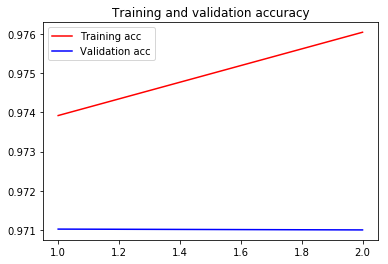

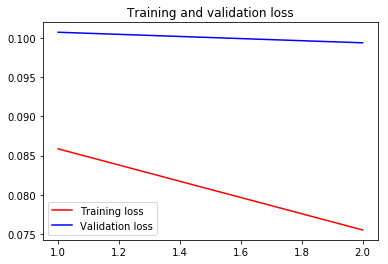

In [21]:
import matplotlib.pyplot as plt

acc = model_history.history['acc']
val_acc = model_history.history['val_acc']
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')
plt.legend()

plt.show()

### Further Imporovements

1.We can also use the sub-headings for each category and concatenate each of the resprective sub-headings with the headings to captures more features from a text.In that case,we will have to increase our max_length.<br/>

2.We can also increase our size of vocabulary if computation is not a bottleneck.<br/>

3.We can add a convolutional layer with multiple filter widths and feature maps.<br/>

